In [1]:
import numpy as np
import matplotlib.pyplot as plt
import irf
from irf.ensemble import wrf as rfc
from irf.utils import (
    get_prevalent_interactions,
    visualize_impurity_decrease,
    visualize_prevalent_interactions,
    get_filtered_feature_paths
)
import rpy2.robjects as robjects
from irf.irf_jupyter_utils import draw_tree

# Simulate the settings in the signed iRF paper

## Simulation 1: and rule

In [2]:
def f(X):
    t = 1 - 0.1 ** .25
    X1 = X[:, [45, 49, 63, 74]]
    q = np.quantile(X1, t1, axis=0)
    return 0.8 * np.alltrue(X1 > q , axis=1)

$
P(Y = 1) = 0.8 \cdot 
1(X_{45} > t_1, X_{49} > t_1, X_{63} > t_1, X_{74} > t_1) 
$
where $t_1 = 1 - 0.1^{1/4}$.

In [3]:
def load_data(i=0):
    robjects.r['load']("../data/enhancer_sim_and.Rdata")
    raw = np.array(robjects.r['data'][i])
    len_train_id = int(raw[-1])
    train_id = raw[-(len_train_id + 1):-1].astype(int) - 1
    
    X = np.array(robjects.r['data'][i])[:7809 * 80].reshape((80, 7809)).T
    y = np.array(robjects.r['data'][i])[7809*80:7809*81]
    return X[train_id], y[train_id]

In [4]:
X, y = load_data(19)

In [5]:
rf = rfc()

In [6]:
rf.fit(X, y, keep_record=False)

wrf(bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion='gini',
    max_depth=None, max_features='auto', max_leaf_nodes=None, max_samples=None,
    min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1,
    min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100,
    n_jobs=None, oob_score=False, random_state=None, verbose=0,
    warm_start=False)

<BarContainer object of 80 artists>

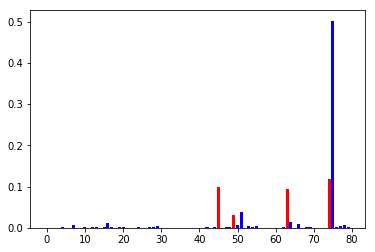

In [7]:
color = ['b' for x in range(80)]
for x in [45, 49, 63, 74]:
    color[x] = 'r'
plt.bar(np.arange(80), rf.feature_importances_, color=color)

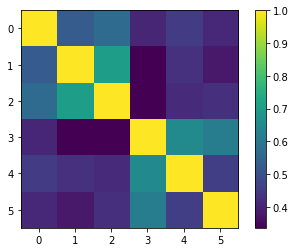

In [8]:
# look at the correlation between y_train and different features
plt.imshow(np.corrcoef(np.vstack([X[:,[45, 49, 63, 74, 75]].T, y.T])))
plt.colorbar()
plt.show()

### Observation: 75 explains 45, 49, 63 better.

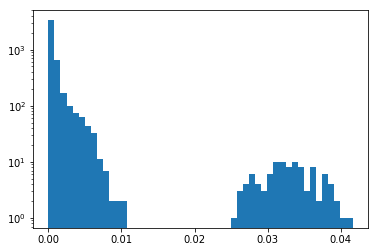

In [9]:
#visualize the impurity decrease of the rf model
visualize_impurity_decrease(rf, xscale='linear', bins=50)

In [10]:
rf.n_paths

4838

In [13]:
#preprocess compute the prevalence
prevalence = get_prevalent_interactions(
    rf,
    impurity_decrease_threshold=0.001,
    min_support=rf.n_paths// 2 ** 5,
    signed=True,
    weight_scheme="depth"
)

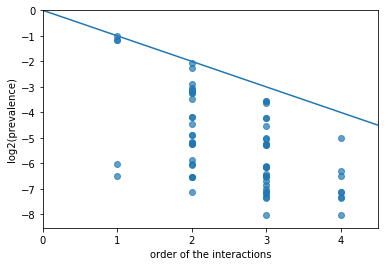

In [14]:
#visualize the interaction plot
visualize_prevalent_interactions(prevalence=prevalence)

In [15]:
list(prevalence.items())[:20]

[(((75, 'R'),), 0.4999999999999977),
 (((74, 'R'), (75, 'L')), 0.23939453124999846),
 (((74, 'R'), (75, 'R')), 0.21097656249999897),
 (((74, 'L'),), 0.4503710937499994),
 (((74, 'R'),), 0.4503710937499968),
 (((63, 'L'), (74, 'R'), (75, 'L')), 0.08529296874999966),
 (((63, 'R'), (74, 'R'), (75, 'L')), 0.08527343749999979),
 (((45, 'R'), (74, 'R'), (75, 'R')), 0.08101562499999944),
 (((45, 'R'), (63, 'R'), (74, 'R'), (75, 'L')), 0.03070312499999986),
 (((45, 'L'), (74, 'R'), (75, 'L')), 0.054296874999999974),
 (((45, 'R'), (74, 'R'), (75, 'L')), 0.05429687499999973),
 (((45, 'R'), (74, 'R')), 0.1353124999999994),
 (((45, 'R'), (63, 'R'), (74, 'R')), 0.04322265624999981),
 (((45, 'L'), (74, 'R')), 0.12249999999999965),
 (((63, 'R'), (74, 'R')), 0.11583984374999956),
 (((45, 'R'), (63, 'R'), (74, 'R'), (75, 'R')), 0.012519531249999936),
 (((63, 'L'), (74, 'R')), 0.1114843749999996),
 (((45, 'L'), (75, 'R')), 0.10601562499999997),
 (((45, 'R'), (75, 'R')), 0.10601562499999938),
 (((45, 'R'

## Simulation 2: OR rule

In [222]:
def f(X):
    t1 = 1 - 0.1 ** .25
    t2 = 1 - 0.25 ** .25
    X1 = X[:, [45, 74]]
    q11 = np.quantile(X1, t1, axis=0)
    q12 = np.quantile(X1, 1 - t2, axis=0)
    X2 = X[:, [49, 63]]
    q21 = np.quantile(X2, 1 - t1, axis=0)
    q22 = np.quantile(X2, t2, axis=0)
    return 0.4 * np.logical_or(
        np.alltrue(X1 > q11 , axis=1) * np.alltrue(X2 <= q21 , axis=1),
        np.alltrue(X1 <= q12, axis=1) * np.alltrue(X2 > q22, axis=1)
    )

In [13]:
def f(X):
    t1 = 1 - 0.1 ** .25
    t2 = 1 - 0.25 ** .25
    X1 = X[:, [45, 74]]
    q11 = np.quantile(X1, t1, axis=0)
    q12 = np.quantile(X1, 1 - t2, axis=0)
    X2 = X[:, [49, 63]]
    q21 = np.quantile(X2, 1 - t1, axis=0)
    q22 = np.quantile(X2, t2, axis=0)
    print(q12[1])
    return (
        np.alltrue(X[:, [45]] <= q12[0], axis=1) * np.alltrue(X2 > q22, axis=1)
    )

$
P(Y = 1) = 0.4 \cdot 
\left(
1(X_{45} > t_1, X_{74} > t_1, X_{49} < 1 - t_1, X_{63} < 1 - t_1) + 
1(X_{49} > t_2, X_{63} > t_2, X_{45} < 1 - t_2, X_{74} < 1 - t_2)
\right)
$
where $t_1 = 1 - 0.1^{1/4}$ and $t_2 = 1 - 0.25^{1/4}$.

0.0


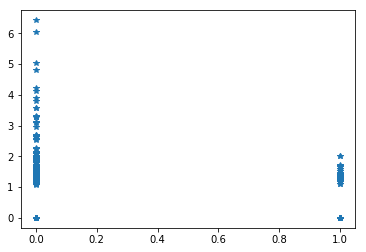

In [14]:
plt.plot(f(X), X[:, 74], '*')

0.0


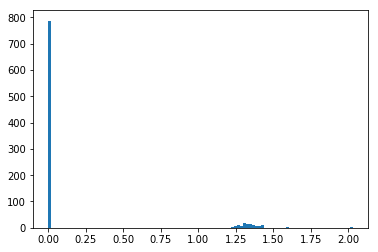

In [18]:
plt.hist(X[f(X) > 0.1, 74],100)
plt.show()

In [16]:
def load_data(i=0):
    robjects.r['load']("../data/enhancer_sim_or.Rdata")
    raw = np.array(robjects.r['data'][i])
    len_train_id = int(raw[-1])
    train_id = raw[-(len_train_id + 1):-1].astype(int) - 1
    
    X = np.array(robjects.r['data'][i])[:7809 * 80].reshape((80, 7809)).T
    y = np.array(robjects.r['data'][i])[7809*80:7809*81]
    return X[train_id], y[train_id]
    #return X, y

In [17]:
X, y = load_data(1)

In [18]:
rf = rfc()

In [19]:
rf.fit(X, y, keep_record=False)

wrf(bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion='gini',
    max_depth=None, max_features='auto', max_leaf_nodes=None, max_samples=None,
    min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1,
    min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100,
    n_jobs=None, oob_score=False, random_state=None, verbose=0,
    warm_start=False)

<BarContainer object of 80 artists>

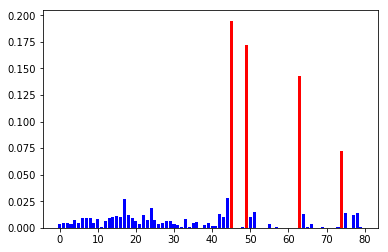

In [20]:
color = ['b' for x in range(80)]
for x in [45, 49, 63, 74]:
    color[x] = 'r'
plt.bar(
    np.arange(80),
    rf.feature_importances_,
    color = color,
)

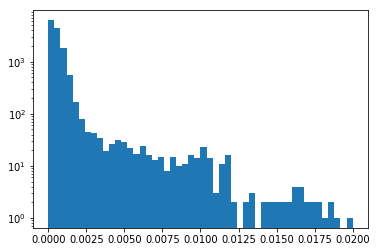

In [21]:
#visualize the impurity decrease of the rf model
visualize_impurity_decrease(rf, xscale='linear', bins=50)

In [22]:
#preprocess compute the prevalence
prevalence = get_prevalent_interactions(rf, impurity_decrease_threshold=1e-3, min_support=rf.n_paths // 2 ** 5, signed=True)

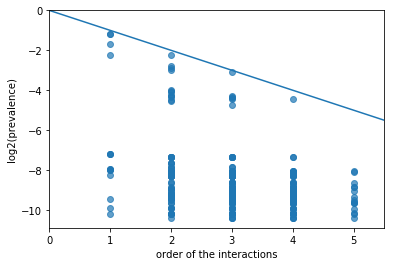

In [23]:
#visualize the interaction plot
visualize_prevalent_interactions(prevalence=prevalence)

In [24]:
#visualize find out the most prevalent interactions
list(prevalence.items())[:20]

[(((45, 'L'), (49, 'R'), (63, 'R')), 0.11890625000000227),
 (((45, 'L'), (49, 'R'), (63, 'R'), (74, 'L')), 0.046757812500000585),
 (((45, 'L'), (63, 'R')), 0.2153125000000049),
 (((63, 'R'),), 0.43906250000001457),
 (((63, 'L'),), 0.43906249999999847),
 (((49, 'R'), (63, 'R')), 0.14515625000000337),
 (((45, 'R'), (63, 'L'), (74, 'R')), 0.05171874999999977),
 (((63, 'L'), (74, 'R')), 0.13619140624999954),
 (((45, 'L'), (63, 'R'), (74, 'L')), 0.05003906250000067),
 (((49, 'R'), (63, 'R'), (74, 'L')), 0.04738281250000059),
 (((45, 'L'), (49, 'R'), (74, 'L')), 0.046757812500000585),
 (((45, 'L'), (49, 'R')), 0.1271875000000023),
 (((49, 'L'), (63, 'L'), (74, 'R')), 0.0371289062499998),
 (((17, 'R'), (45, 'L'), (49, 'R'), (63, 'R'), (74, 'L')),
  0.0037791538238525287),
 (((17, 'L'), (45, 'L'), (49, 'R'), (63, 'R'), (74, 'L')),
  0.003701028823852525),
 (((45, 'L'),), 0.3079687500000087),
 (((44, 'R'), (45, 'L'), (49, 'R'), (63, 'R'), (74, 'L')),
  0.0024825310707092194),
 (((45, 'L'), (49,

## Simulation 3: Add rule

$P(Y=1) = 0.4 \cdot (1(X_{49} > t, X_{53} > t, X_{63} > t) + 1(X_{45} > t, X_{74} > t, X_{77} > t))$ where t is the $1 - 0.1^{1/4}$ quantile.

In [25]:
def f(X):
    t = 1 - 0.1 ** .25
    X1 = X[:, [49, 53, 63]]
    q1 = np.quantile(X1, t, axis=0)
    X2 = X[:, [45, 74, 77]]
    q2 = np.quantile(X2, t, axis=0)
    return 0.4 * (np.alltrue(X1 > q1, axis=1) * 1.0 + np.alltrue(X2 > q2, axis=1))

In [26]:
def load_data(i=0):
    robjects.r['load']("../data/enhancer_sim_add.Rdata")
    raw = np.array(robjects.r['data'][i])
    len_train_id = int(raw[-1])
    train_id = raw[-(len_train_id + 1):-1].astype(int) - 1
    
    X = np.array(robjects.r['data'][i])[:7809 * 80].reshape((80, 7809)).T
    y = np.array(robjects.r['data'][i])[7809*80:7809*81]
    return X[train_id], y[train_id]

In [27]:
X, y = load_data(2)

In [28]:
rf = rfc()

In [29]:
rf.fit(X, y, keep_record=False)

wrf(bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion='gini',
    max_depth=None, max_features='auto', max_leaf_nodes=None, max_samples=None,
    min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1,
    min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100,
    n_jobs=None, oob_score=False, random_state=None, verbose=0,
    warm_start=False)

<BarContainer object of 80 artists>

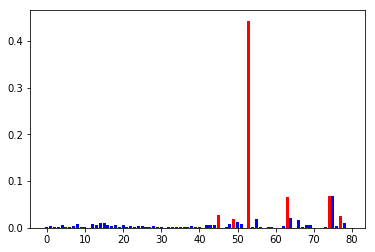

In [30]:
color = ['b' for x in range(80)]
for x in [49, 53, 63] + [45, 74, 77]:
    color[x] = 'r'
plt.bar(np.arange(80), rf.feature_importances_, color=color)

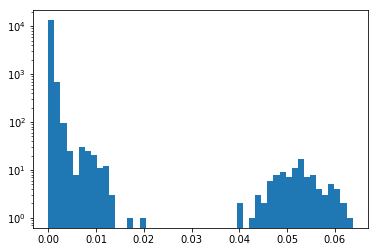

In [31]:
#visualize the impurity decrease of the rf model
visualize_impurity_decrease(rf, xscale='linear', bins=50)

In [32]:
#preprocess compute the prevalence
prevalence = get_prevalent_interactions(rf, impurity_decrease_threshold=0.001, min_support=rf.n_paths//2 ** 7, signed=True)

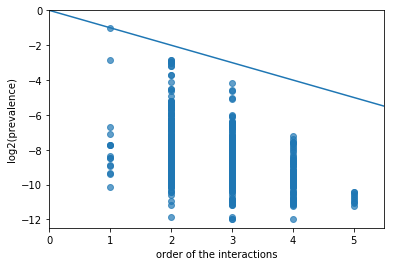

In [33]:
#visualize the interaction plot
visualize_prevalent_interactions(prevalence=prevalence)

In [34]:
#visualize find out the most prevalent interactions
list(prevalence.items())[:20]

[(((53, 'R'),), 0.5000000000000033),
 (((53, 'R'), (63, 'R'), (74, 'L')), 0.05526367187499984),
 (((53, 'R'), (74, 'L')), 0.14054687500000024),
 (((53, 'R'), (74, 'R')), 0.1405468749999991),
 (((53, 'L'), (74, 'L')), 0.12589843749999968),
 (((53, 'L'), (74, 'R')), 0.12589843749999927),
 (((53, 'R'), (63, 'L'), (74, 'L')), 0.042568359375),
 (((53, 'R'), (63, 'L')), 0.12135742187499966),
 (((53, 'R'), (63, 'R')), 0.12135742187499947),
 (((53, 'R'), (63, 'R'), (75, 'L')), 0.040871582031249805),
 (((53, 'R'), (75, 'R')), 0.10970458984374964),
 (((53, 'R'), (75, 'L')), 0.10970458984374933),
 (((53, 'R'), (63, 'L'), (75, 'L')), 0.03044921874999998),
 (((53, 'R'), (63, 'R'), (74, 'R')), 0.029179687499999944),
 (((53, 'R'), (63, 'R'), (74, 'L'), (75, 'L')), 0.00684814453124998),
 (((53, 'R'), (63, 'R'), (74, 'R'), (75, 'L')), 0.005957031249999999),
 (((53, 'L'), (75, 'R')), 0.07662109374999991),
 (((53, 'L'), (75, 'L')), 0.0766210937499996),
 (((53, 'R'), (55, 'L'), (63, 'R'), (75, 'L')), 0.00